# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [1]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-01-08 22:12:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.66.219, 142.250.204.27, 142.250.66.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.66.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  12.0MB/s    in 2m 7s   

2025-01-08 22:14:21 (12.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [2]:
!rm "101_food_classes_10_percent.zip"

rm: 101_food_classes_10_percent.zip: No such file or directory


In [3]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [4]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_class

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             label_mode="categorical",
                                                             image_size=IMG_SIZE,
                                                             shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.


2025-01-09 11:30:10.092106: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-01-09 11:30:10.092140: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-09 11:30:10.092152: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-09 11:30:10.092438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-09 11:30:10.092455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [6]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [7]:
# Create data augmentation layer to incorporate it right into the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    # layers.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

In [10]:
# Setup the base model amd freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay froze
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
# Get a summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5


2025-01-09 12:54:37.010376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


237/237 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.1491 - loss: 3.9821 - val_accuracy: 0.4635 - val_loss: 2.5094
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - accuracy: 0.4814 - loss: 2.3457 - val_accuracy: 0.5185 - val_loss: 2.0396
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.5471 - loss: 1.9276 - val_accuracy: 0.5403 - val_loss: 1.8637
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 698s 3s/step - accuracy: 0.5858 - loss: 1.6953 - val_accuracy: 0.5389 - val_loss: 1.7979
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 751s 3s/step - accuracy: 0.6242 - loss: 1.5366 - val_accuracy: 0.5564 - val_loss: 1.7386


In [13]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 150s 189ms/step - accuracy: 0.5719 - loss: 1.6625


[1.575093150138855, 0.58863365650177]

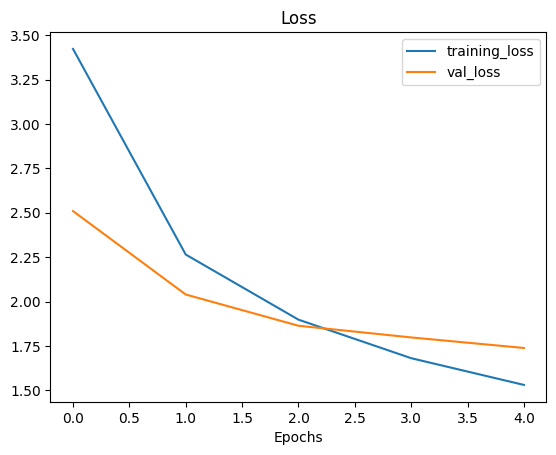

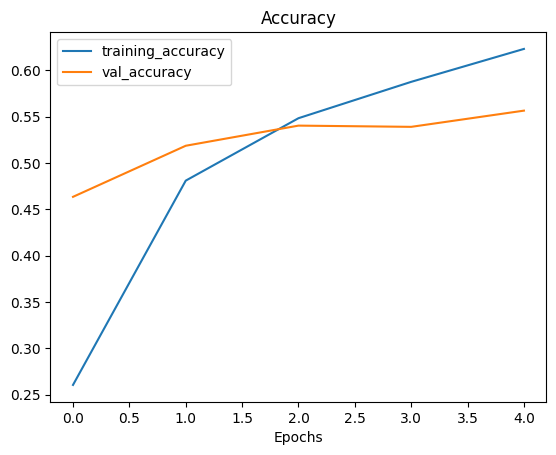

In [14]:
plot_loss_curves(history_all_classes_10_percent)